# Waypoint based obstacle avoidance DPC

I call it wp_p2p which stands for waypoint point to point, but the title is more accurate ^

In [1]:
import torch 

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import BarrierLoss
from neuromancer.modules import blocks
from neuromancer.plot import pltCL
from neuromancer.dynamics import integrators, ode

# replacing this dependancy so that you don't need to install my repo.
# from dpc_sf.utils import pytorch_utils as ptu
class Ptu:
    def __init__(self) -> None:
        
        self.device = None
        self.dtype = torch.float32

    def init_gpu(self, use_gpu=True, gpu_id=0):
        global device
        if torch.cuda.is_available() and use_gpu:
            device = torch.device("cuda:" + str(gpu_id))
            print("Using GPU id {}".format(gpu_id))
        else:
            device = torch.device("cpu")
            print("GPU not detected. Defaulting to CPU.")

    def init_dtype(self, set_dtype=torch.float32):
        global dtype
        dtype = set_dtype
        print(f"Use dtype: {dtype}")

    def set_device(self, gpu_id):
        torch.cuda.set_device(gpu_id)

    def from_numpy(self, *args, **kwargs):
        return torch.from_numpy(*args, **kwargs).type(self.dtype).to(self.device)

    def to_numpy(self, tensor):
        return tensor.to('cpu').detach().numpy()

    def create_tensor(self, list):
        return torch.tensor(list).type(self.dtype).to(self.device)

    def create_zeros(self, shape):
        return torch.zeros(shape).type(self.dtype).to(self.device)
ptu = Ptu()

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(0)

## Options

In [2]:
radius = 0.5                        # radius of the cylinder to be avoided
save_path = "policy/DPC/"           # as you would expect - the path where I save the policies
nstep = 100                         # the number of timesteps in the horizon
epochs = 10                         # the number of training epochs per iteration
iterations = 3                      # the number of times a new dataset is generated and another set of training epochs done using it
lr = 0.01                           # learning rate
Ts = 0.1                            # timestep
minibatch_size = 10                 # do autograd per minibatch_size, what is fed to the torch dataloader
batch_size = 500                    # the number of start and end points in the dataset used to train
x_range = 3.                        # multiplier of torch.randn(1, 1, nx) for the initial states in the dataset
r_range = 3.                        # same multiplier for the torch.randn(1, 1, nx) for the reference end points in the dataset
cyl_range = 3.                      # same thing for the cylinder center location
use_integrator = False              # whether or not we use an integrator in tandem with the MLP
use_rad_multiplier = False          # whether or not we increase the radius over the horizon so as to encourage distance from the constraint
train = True                        # whether or not to do the training or just run an inference on the last trained system
use_terminal_state_penalty = True   # to use a terminal state penalty in the cost function or not
Q_con = 1_000_000.
Q_terminal = 10_000.
delta_terminal = 0.1

## Triple Double Integrator Definition

In [3]:
nx = 6 # state size
nr = 6 # reference size
nu = 3 # input size
nc = 2 # cylinder coordinates size

interp_u = lambda tq, t, u: u

A = torch.tensor([
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
])

B = torch.tensor([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0]
])

## Neuromancer System Definition

The cylinder variable is of form (x,y) defining its center:

$$\text{cyl} = \left\{ x, y \right\}$$

The state is of form (position, velocity) repeated:

$$\pmb{x} = \left\{ x, \dot{x}, y, \dot{y}, z, \dot{z} \right\}$$

The reference is of form (position, velocity) repeated:

$$\pmb{r} = \left\{ x, \dot{x}, y, \dot{y}, z, \dot{z} \right\}$$

The input is of form (thrust x, thrust y, thrust z):

$$\pmb{u} = \left\{ T_x, T_y, T_z \right\}$$

The idx, and m variables are scalar for a given timestep and batch

The integrated error is of form (integrated error x, y, z):

$$I_{err} = \left\{ I_{x_{err}}, I_{y_{err}}, I_{z_{err}} \right\}$$

In [4]:
# variables
cyl = variable('Cyl')       # the cylinder center coordinates
r = variable('R')           # the reference
u = variable('U')           # the input
x = variable('X')           # the state
idx = variable('Idx')       # the index of the current timestep into the horizon, used to find m below.
m = variable('M')           # radius multiplier, increase radius into horizon future
I_err = variable('I_err')   # the integrated error term used by the integrator policy

In [5]:
# Classes:
class Dynamics(ode.ODESystem):
    def __init__(self, insize, outsize) -> None:
        super().__init__(insize=insize, outsize=outsize)
        self.f = lambda x, u: x @ A.T + u @ B.T
        self.in_features = insize
        self.out_features = outsize

    def ode_equations(self, xu):
        x = xu[:,0:6]
        u = xu[:,6:9]
        return self.f(x,u)


class IntegratorPolicy(torch.nn.Module):
    def __init__(
            self, 
            init_gain, 
            bs=1,
            insize=nx + nr + nc + 3, 
            outsize=nu, 
            bias=True,
            linear_map=torch.nn.Linear,
            nonlin=torch.nn.ReLU,
            hsizes=[20, 20, 20, 20]
        ) -> None:
        super().__init__()
        self.gain = init_gain
        # self.int_error = ptu.create_zeros([bs, 3])
        self.mlp = blocks.MLP(
            insize=insize, outsize=outsize, bias=bias,
            linear_map=linear_map,
            nonlin=nonlin,
            hsizes=hsizes
        )

        # anti windup minimum and maximum integration error
        self.int_err_min = ptu.create_zeros([bs, 3])
        self.int_err_min += ptu.create_tensor([[-50, -50, -50]])

        self.int_err_max = ptu.create_zeros([bs, 3])
        self.int_err_max += ptu.create_tensor([[50, 50, 50]])

    def forward(self, xrc, i_err):

        xrci = torch.hstack([xrc, i_err])

        # NN policy generated u
        mlp_u = self.mlp(xrci)

        # integrator generated u
        i_u = self.gain * i_err

        # add up the inputs to form the final u
        u = mlp_u + i_u

        # calculate the integrated error for the next timestep
        x = xrc[:,0:6]
        r = xrc[:,6:12]

        # error in {x, xdot, y, ydot, z, zdot}
        err = r - x

        # error in {x, y, z}
        pos_err = err[:,::2]

        # add the current error to the running total in i_err
        i_err  = i_err + pos_err

        # anti windup clip the integration error
        i_err = torch.clip(i_err, min = self.int_err_min, max = self.int_err_max)

        return u, i_err

class Cat(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, *args):
        # expects shape [bs, nx]
        return torch.hstack(args)

class radMultiplier(torch.nn.Module):
    def __init__(self, Ts, bs=1) -> None:
        super().__init__()
        self.Ts = Ts
        self.bs = bs

    def forward(self, i):
        # multiplier = 1 + idx * Ts * 0.5
        m = 1 + i * self.Ts * 0.01 # 0.15 # 0.5
        i = i + 1
        return i, m

In [6]:
# Nodes:
node_list = []

if use_rad_multiplier:

    rad_multiplier = radMultiplier(Ts=Ts, bs=batch_size)
    rad_multiplier_node = Node(rad_multiplier, ['Idx'], ['Idx', 'M'], name='rad_multiplier')
    node_list.append(rad_multiplier_node)

state_ref_cat = Cat()
state_ref_cat_node = Node(state_ref_cat, ['X', 'R', 'Cyl'], ['XRC'], name='cat')
node_list.append(state_ref_cat_node)

if use_integrator is True:

    policy = IntegratorPolicy(
        init_gain=ptu.create_tensor([0.1,0.1,0.1]),
        insize=nx + nr + nc + 3, outsize=nu, bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ReLU,
        hsizes=[20, 20, 20, 20]
    )
    policy_node = Node(policy, ['XRC', 'I_err'], ['U', 'I_err'], name='policy')
    node_list.append(policy_node)

elif use_integrator is False:
    policy = blocks.MLP(
        insize=nx + nr + nc, outsize=nu, bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ReLU,
        hsizes=[20, 20, 20, 20]
    )
    policy_node = Node(policy, ['XRC'], ['U'], name='policy')
    node_list.append(policy_node)
else:
    print("invalid integrator choice detected")

dynamics = Dynamics(insize=9, outsize=6)
integrator = integrators.Euler(dynamics, interp_u=interp_u, h=torch.tensor(Ts))
dynamics_node = Node(integrator, ['X', 'U'], ['X'], name='dynamics')
node_list.append(dynamics_node)

print(f'node list used in cl_system: {node_list}')
cl_system = System(node_list)
# cl_system.show() # I cannot run the .show() in the notebook (pydot issues), but I can run in debug mode?

node list used in cl_system: [cat(X, R, Cyl) -> XRC, policy(XRC) -> U, dynamics(X, U) -> X]


## Dataset Generation

Algorithm for dataset generation:

- we randomly sample 3 points for each rollout, quad start state, quad reference state, cylinder position
- if a particular datapoint has a start or reference state that is contained within the random cylinder 
  we discard that datapoint and try again. The output of this is a "filtered" dataset in "get_filtered_dataset"
- I also have a validation function to check the filtered datasets produced here, but you can ignore that
- these filtered datasets are then wrapped in DictDatasets and then wrapped in torch dataloaders

NOTE:
- the minibatch size used in the torch dataloader can play a key role in reducing the final steady state error
  of the system
    - If the minibatch is too large we will not get minimal steady state error, minibatch of 10 has proven good

In [7]:
# average end position, for if we want to go to a certain location more than others, 0. if not
end_pos = ptu.create_tensor([[[0.0,0.0,0.0,0.0,0.0,0.0]]])

def is_inside_cylinder(x, y, cx, cy, radius=radius):
    """
    Check if a point (x,y) is inside a cylinder with center (cx, cy) and given radius.
    """
    distance = torch.sqrt((x - cx) ** 2 + (y - cy) ** 2)
    return distance < radius

def get_filtered_dataset(batch_size, nx, nstep, x_range, r_range, end_pos, cyl_range):    
    """
    Generate a filtered dataset of samples where none of the state or reference points are inside a cylinder.

    Parameters:
    - batch_size (int): Desired number of data samples in the batch.
    - nx (int): Dimension of the state sample.
    - nstep (int): Number of steps for reference and cylinder data.
    - x_range (float): Scaling factor for state data.
    - r_range (float): Scaling factor for reference data.
    - end_pos (float): Constant offset for reference data.
    - cyl_range (float): Scaling factor for cylinder data.

    Returns:
    - dict: A dictionary containing:
        'X': Tensor of state data of shape [batch_size, 1, nx].
        'R': Tensor of reference data of shape [batch_size, nstep + 1, nx].
        'Cyl': Tensor of cylinder data of shape [batch_size, nstep + 1, 2].
        'Idx': Zero tensor indicating starting index for each sample in batch.
        'M': Tensor with ones indicating starting multiplier for each sample.
        'I_err': Zero tensor indicating initial error for each sample in batch.

    """
    X = []
    R = []
    Cyl = []
    
    # Loop until the desired batch size is reached.
    print(f"generating dataset of batchsize: {batch_size}")
    while len(X) < batch_size:
        x_sample = x_range * torch.randn(1, 1, nx)
        r_sample = torch.concatenate([r_range * torch.randn(1, 1, nx)] * (nstep + 1), dim=1) + end_pos
        cyl_sample = torch.concatenate([cyl_range * torch.randn(1, 1, 2)] * (nstep + 1), dim=1)
        
        inside_cyl = False
        
        # Check if any state or reference point is inside the cylinder.
        for t in range(nstep + 1):
            if is_inside_cylinder(x_sample[0, 0, 0], x_sample[0, 0, 2], cyl_sample[0, t, 0], cyl_sample[0, t, 1]):
                inside_cyl = True
                break
            if is_inside_cylinder(r_sample[0, t, 0], r_sample[0, t, 2], cyl_sample[0, t, 0], cyl_sample[0, t, 1]):
                inside_cyl = True
                break
        
        if not inside_cyl:
            X.append(x_sample)
            R.append(r_sample)
            Cyl.append(cyl_sample)
    
    # Convert lists to tensors.
    X = torch.cat(X, dim=0)
    R = torch.cat(R, dim=0)
    Cyl = torch.cat(Cyl, dim=0)
    
    return {
        'X': X,
        'R': R,
        'Cyl': Cyl,
        'Idx': ptu.create_zeros([batch_size,1,1]), # start idx
        'M': torch.ones([batch_size, 1, 1]), # start multiplier
        'I_err': ptu.create_zeros([batch_size,1,3])
    }

def validate_dataset(dataset):
    X = dataset['X']
    R = dataset['R']
    Cyl = dataset['Cyl']
    
    batch_size = X.shape[0]
    nstep = R.shape[1] - 1

    print("validating dataset...")
    for i in range(batch_size):
        for t in range(nstep + 1):
            # Check initial state.
            if is_inside_cylinder(X[i, 0, 0], X[i, 0, 2], Cyl[i, t, 0], Cyl[i, t, 1]):
                return False, f"Initial state at index {i} lies inside the cylinder."
            # Check each reference point.
            if is_inside_cylinder(R[i, t, 0], R[i, t, 2], Cyl[i, t, 0], Cyl[i, t, 1]):
                return False, f"Reference at time {t} for batch index {i} lies inside the cylinder."

    return True, "All points are outside the cylinder."

In [8]:
def get_loaders(batch_size, nx, nstep, x_range, r_range, end_pos, cyl_range):
    train_data = DictDataset(get_filtered_dataset(
        batch_size=batch_size,
        nx = nx,
        nstep = nstep,
        x_range = x_range,
        r_range = r_range,
        end_pos = end_pos,
        cyl_range = cyl_range,
    ), name='train')

    dev_data = DictDataset(get_filtered_dataset(
        batch_size=batch_size,
        nx = nx,
        nstep = nstep,
        x_range = x_range,
        r_range = r_range,
        end_pos = end_pos,
        cyl_range = cyl_range,
    ), name='dev')

    validate_dataset(train_data.datadict)
    validate_dataset(dev_data.datadict)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=minibatch_size,
                                            collate_fn=train_data.collate_fn, shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=minibatch_size,
                                            collate_fn=dev_data.collate_fn, shuffle=False)
    
    return train_loader, dev_loader



generating dataset of batchsize: 500


generating dataset of batchsize: 500
validating dataset...
validating dataset...


## Optimisation Problem Setup

NOTE:
- Use of a BarrierLoss, which provides a loss which increases the closer to a constraint violation
  we come, has proven much more effective than a PenaltyLoss in obstacle avoidance. The PenaltyLoss 
  is either on or off, and so has a poor learning signal for differentiable problems, but the BarrierLoss
  provides a constant learning signal which has proven effective.
- Not penalising velocity, and only position has frequently led to controllers that do not converge
  to zero velocity, and therefore drift over time. Therefore velocities have been kept in the 
  regulation loss term.

In [9]:
# THE OLD WORKING CONSTRAINT
# Q_con = 1000000.
# cylinder_constraint = Q_con * ((radius**2 * multiplier <= (x[:,:,0]-cyl[:,:,0])**2 + (x[:,:,2]-cyl[:,:,1])**2)) ^ 2

## Training

NOTE:
- Multiple iterations with new datasets at lower learning rates has proven very effective at generating
  superior policies

In [11]:
best_model = None
if train is True:
    # Train model with prediction horizon of train_nsteps
    for i in range(iterations):
        print(f'training with prediction horizon: {nstep}, lr: {lr}')

        # Get Datasets
        # ------------
        train_loader, dev_loader = get_loaders(
            batch_size=batch_size,
            nx=nx,
            nstep=nstep,
            x_range=x_range,
            r_range=r_range,
            end_pos=end_pos,
            cyl_range=cyl_range    
        )

        # Define Constraints
        # ------------------
        constraints = []
        Q_con = 1000000.
        cylinder_constraint = Q_con * ((radius**2 * m[:,:,0] <= (x[:,:,0]-cyl[:,:,0])**2 + (x[:,:,2]-cyl[:,:,1])**2)) ^ 2
        constraints.append(cylinder_constraint)

        if use_terminal_state_penalty is True:

            terminal_lower_bound_penalty = Q_terminal * (x[:,-1,:] > r[:,-1,:] - delta_terminal)
            terminal_upper_bound_penalty = Q_terminal * (x[:,-1,:] < r[:,-1,:] + delta_terminal)
            constraints.append(terminal_lower_bound_penalty)
            constraints.append(terminal_upper_bound_penalty)

        # Define Loss
        # -----------
        action_loss = 0.1 * (u == 0.)^2  # control penalty
        regulation_loss = 5. * (x[:,:,:] == r[:,:,:])^2
        objectives = [action_loss, regulation_loss]
        loss = BarrierLoss(objectives, constraints)

        # Define the Problem and the Trainer
        # ----------------------------------
        problem = Problem([cl_system], loss, grad_inference=True)
        optimizer = torch.optim.AdamW(policy.parameters(), lr=lr)

        trainer = Trainer(
            problem,
            train_loader,
            dev_loader,
            dev_loader,
            optimizer,
            epochs=epochs,
            patience=epochs,
            train_metric="train_loss",
            dev_metric="dev_loss",
            test_metric="test_loss",
            eval_metric='dev_loss',
            warmup=400,
        )

        # Train Over Nsteps
        # -----------------
        cl_system.nsteps = nstep
        if best_model is not None:
            trainer.model.load_state_dict(best_model)
        best_model = trainer.train()

        # Update Parameters for the Next Iteration
        # ----------------------------------------
        lr *= 0.2
        Q_con *= 1
        Q_terminal *= 1
        delta_terminal *= 0.5
        nstep *= 1

        # update the prediction horizon
        cl_system.nsteps = nstep

else:
    best_model = torch.load("policy/DPC/wp_p2p.pth")


training with prediction horizon: 100, lr: 0.01


/Users/vilj909/Code/neuromancer/src/neuromancer/constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 100, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 73111.1484375
epoch: 1  train_loss: 14636.1748046875
epoch: 2  train_loss: 12911.4599609375
epoch: 3  train_loss: 12693.9248046875
epoch: 4  train_loss: 12495.44921875
epoch: 5  train_loss: 12377.0595703125
epoch: 6  train_loss: 12314.1611328125
epoch: 7  train_loss: 12315.8427734375
epoch: 8  train_loss: 12233.275390625
epoch: 9  train_loss: 12163.76953125
generating dataset of batchsize: 500
generating dataset of batchsize: 500
validating dataset...
validating dataset...
training with prediction horizon: 100, lr: 0.002
epoch: 0  train_loss: 11976.927734375
epoch: 1  train_loss: 11926.0966796875
epoch: 2  train_loss: 11921.6533203125
epoch: 3  train_loss: 11916.0478515625
epoch: 4  train_loss: 11912.740234375
epoch: 5  train_loss: 11908.150390625
epoch: 6  train_loss: 11903.5498046875
Interrupted training loop.
generating dataset of batchsize: 500
generating dataset of batchsize: 500
validating dataset...


validating dataset...
training with prediction horizon: 100, lr: 0.0004


## Test Inference

testing model over 100 timesteps...


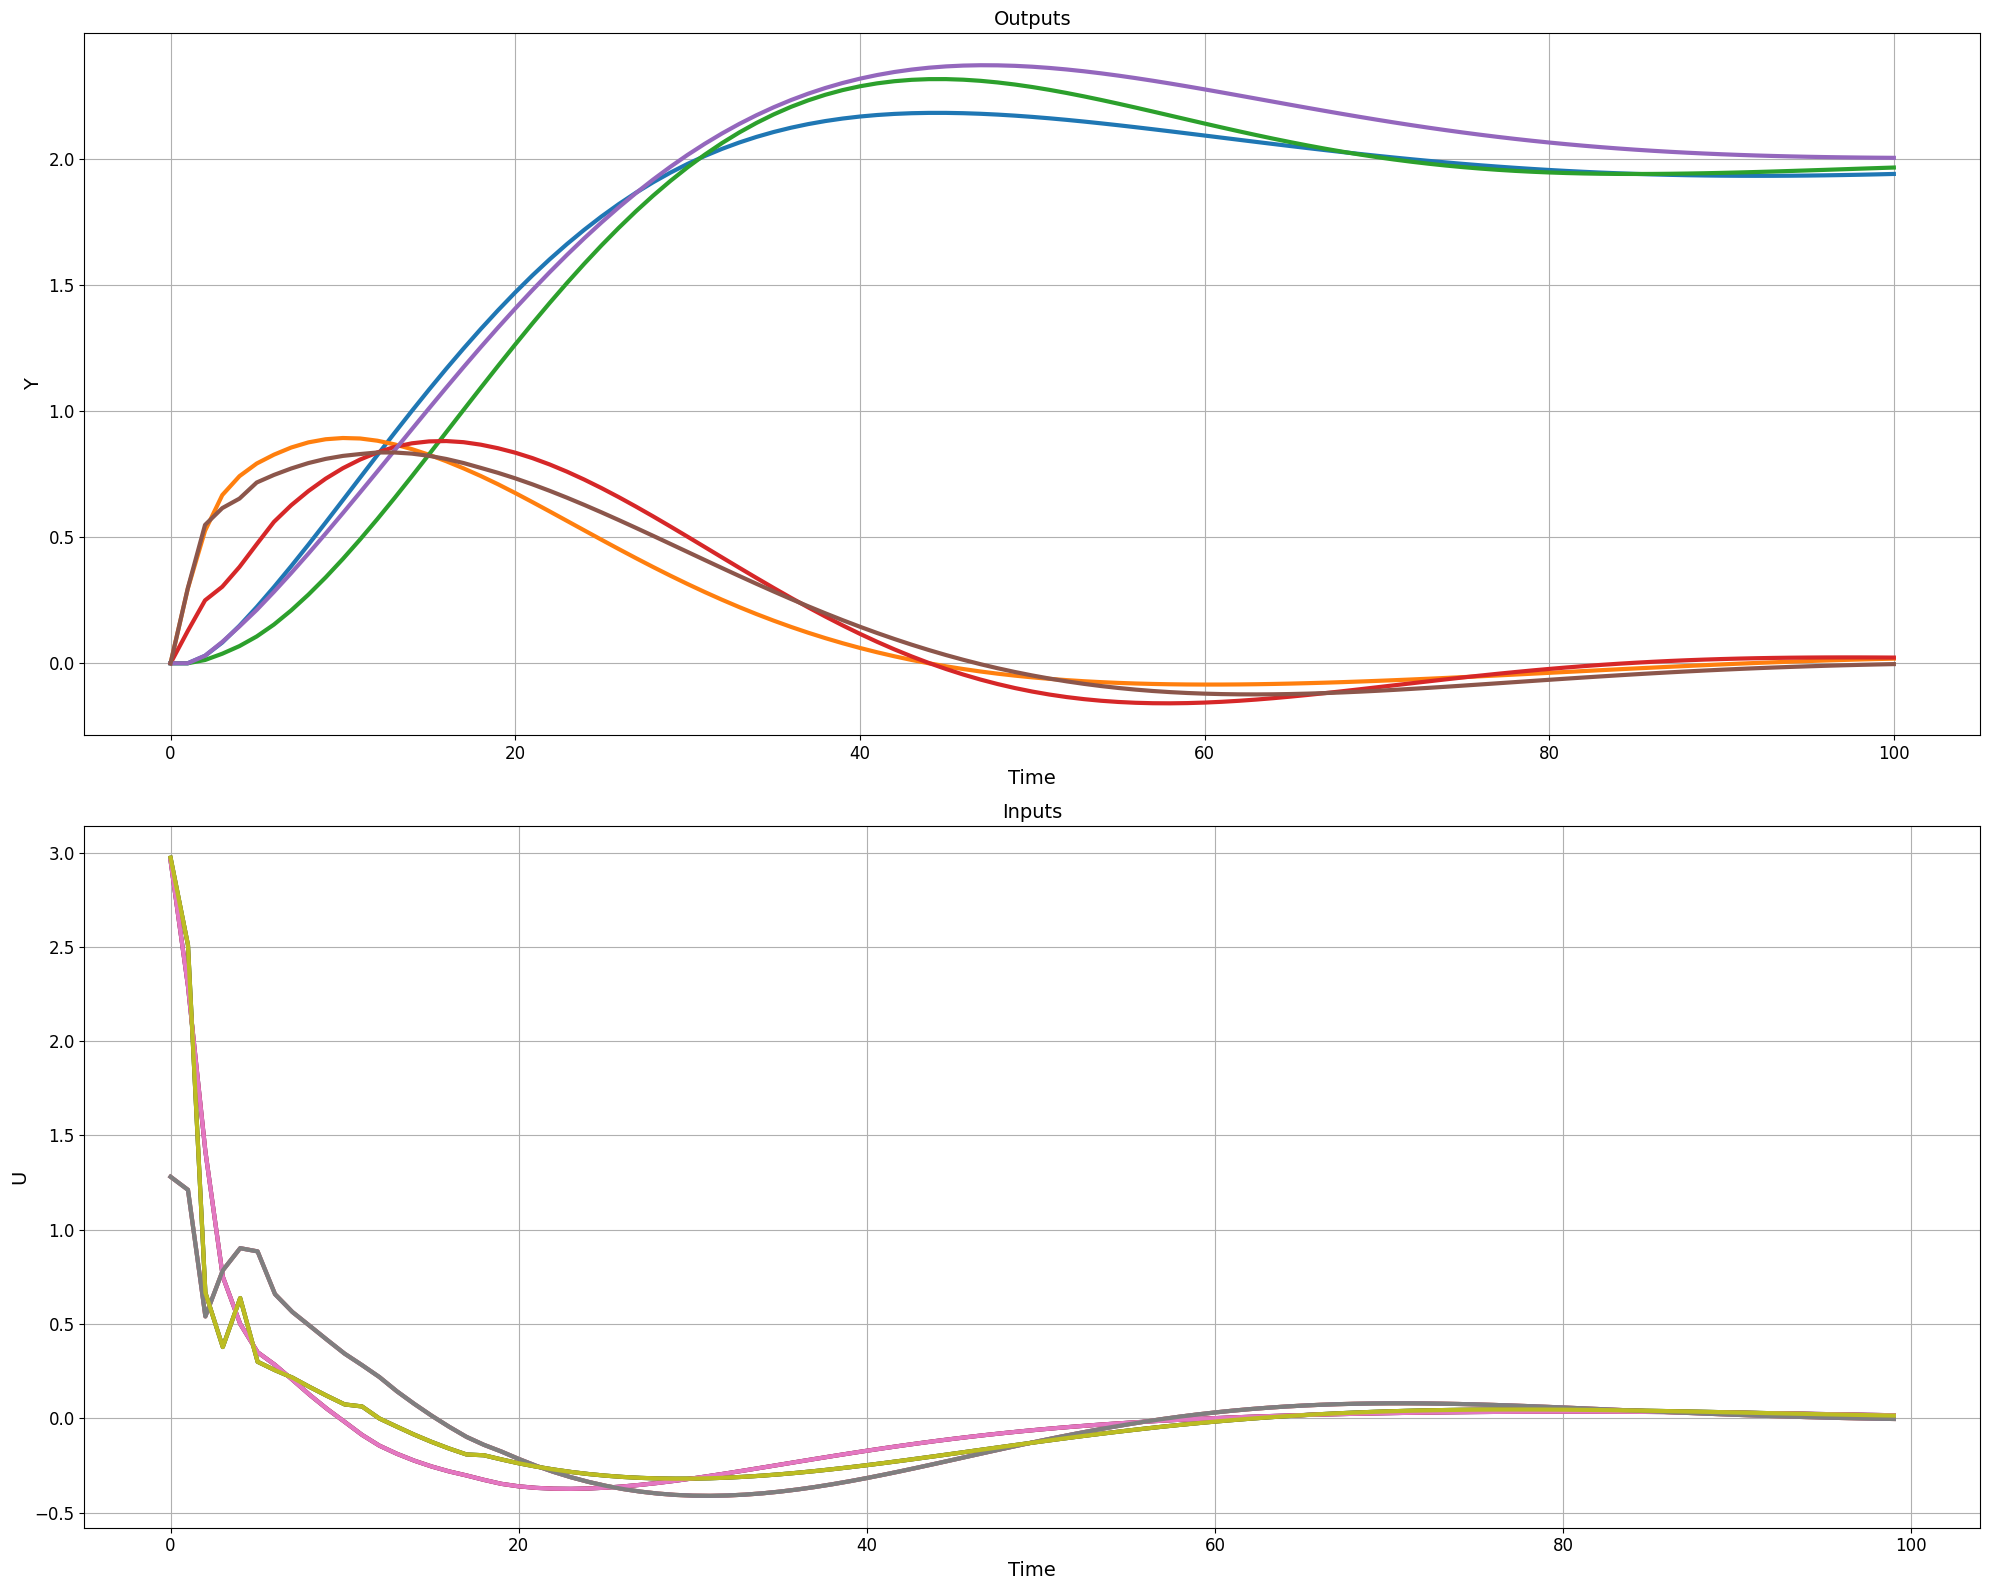

In [ ]:
problem.load_state_dict(best_model)
data = {
    'X': torch.zeros(1, 1, nx, dtype=torch.float32), 
    'R': torch.concatenate([torch.tensor([[[2, 0, 2, 0, 2, 0]]])]*(nstep+1), dim=1), 
    'Cyl': torch.concatenate([torch.tensor([[[1,1]]])]*(nstep+1), dim=1), 
    'Idx': torch.vstack([torch.tensor([0.0])]).unsqueeze(1),
    'M': torch.ones([1, 1, 1]), # start multiplier
    'I_err': ptu.create_zeros([1,1,3])
}
cl_system.nsteps = nstep
print(f"testing model over {nstep} timesteps...")
trajectories = cl_system(data)
pltCL(
    Y=trajectories['X'].detach().reshape(nstep + 1, 6), 
    U=trajectories['U'].detach().reshape(nstep, 3), 
    figname=f'cl.png'
)

## Save

In [ ]:
policy_state_dict = {}
for key, value in best_model.items():
    if "callable." in key:
        new_key = key.split("nodes.0.nodes.2.")[-1]
        policy_state_dict[new_key] = value

if use_integrator is True:
    torch.save(policy_state_dict, "wp_p2p_int.pth")
else:
    torch.save(policy_state_dict, "wp_p2p.pth")